## Part 1: Data Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Perceptron as SklearnPerceptron
from sklearn.linear_model import SGDClassifier
from sklearn.impute import SimpleImputer

In [2]:
# Load the datasets
train_df = pd.read_csv('project_adult.csv', na_values='?', skipinitialspace=True)
X_validation = pd.read_csv('project_validation_inputs.csv', na_values='?', skipinitialspace=True)

# Separate features (X) and target (y) from the training data
X_train_full = train_df.drop('income', axis=1)
y_train_full = train_df['income'].apply(lambda x: 1 if x == '>50K' else 0)

# Identify categorical and numerical features
categorical_features = X_train_full.select_dtypes(include=['object']).columns
numerical_features = X_train_full.select_dtypes(include=['int64', 'float64']).columns

# Preprocessing pipelines for numerical and categorical features

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine the transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Fit and transform the training data
X_train_processed = preprocessor.fit_transform(X_train_full)
X_validation_processed = preprocessor.transform(X_validation)

# Split the processed training data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train_processed, y_train_full, test_size=0.2, random_state=42)

## Part 2: Implementation of Perceptron and Adaline SGD

In [3]:
# Assumption:  This code assumes you have already clean, processed, and split a data set.
'''
Input Data Required:
X_train = cleaned, processed input data for training prediction models
y_train = response variable associated with X_train; truth values
X_test = cleaned, processed input data for testing prediction model created on training dataset
y_test = response variable associated with X_test; truth values

Note: Current order of rows ensure y_train = X_train and y_test = X_test, but if you sort and remove rows this association changes.
'''
# Scikit-learn Perceptron
sk_ppn = SklearnPerceptron(eta0=0.1, max_iter=15, random_state=42)
sk_ppn.fit(X_train, y_train)
sk_y_pred_ppn = sk_ppn.predict(X_test)
print(f"Scikit-learn Perceptron accuracy: {accuracy_score(y_test, sk_y_pred_ppn):.4f}")

# Scikit-learn Adaline (using SGDClassifier with 'log_loss' is closer, but 'perceptron' is available)
# For Adaline (which uses GD), SGDClassifier with 'hinge' loss is a good proxy, as it's a linear classifier with regularization
sk_ada = SGDClassifier(loss='perceptron', eta0=0.0001, learning_rate='constant', max_iter=15, random_state=42)
sk_ada.fit(X_train, y_train)
sk_y_pred_ada = sk_ada.predict(X_test)
print(f"Scikit-learn Adaline (SGDClassifier) accuracy: {accuracy_score(y_test, sk_y_pred_ada):.4f}")

Scikit-learn Perceptron accuracy: 0.7960
Scikit-learn Adaline (SGDClassifier) accuracy: 0.7203


### b. Plot the number of misclassifications (Perceptron) and MSE (Adaline) over epochs

In [4]:
class Perceptron:
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
      Bias unit after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        # if you use libarry versions stated by book use float_, else if new use float64
        # self.b_ = np.float_(0.)
        self.b_ = np.float64(0.)
        
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_ += update * xi
                self.b_ += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)


In [5]:
class AdalineSGD:
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    shuffle : bool (default: True)
      Shuffles training data every epoch if True to prevent cycles.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
        Bias unit after fitting.
    losses_ : list
      Mean squared error loss function value averaged over all
      training examples in each epoch.

        
    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.losses_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            losses = []
            for xi, target in zip(X, y):
                losses.append(self._update_weights(xi, target))
            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)
        return self

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to small random numbers"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=m)
        self.b_ = np.float64(0.)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_ += self.eta * 2.0 * xi * (error)
        self.b_ += self.eta * 2.0 * error
        loss = error**2
        return loss
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)


In [6]:
#Train models
ppn = Perceptron(eta=0.01, n_iter=15, random_state=42)
ppn.fit(X_train.toarray() if hasattr(X_train, "toarray") else X_train, y_train.values)

ada = AdalineSGD(eta=0.01, n_iter=15, random_state=20)
ada.fit(X_train.toarray() if hasattr(X_train, "toarray") else X_train, y_train.values)

/var/folders/rr/0k6zwnnj6x17cpm35lnzy2xh0000gn/T/ipykernel_50415/2708435123.py:93: RuntimeWarning: overflow encountered in double_scalars
  loss = error**2
/Users/sarahmcbride/miniconda3/envs/pyml-book/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


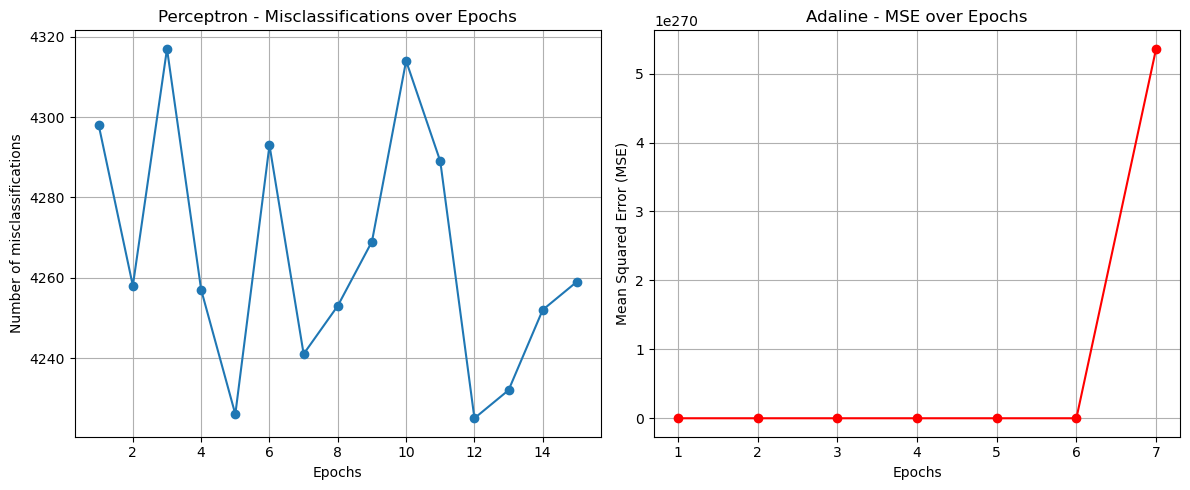

In [7]:
# Create subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
# Plot Perceptron misclassifications
ax[0].plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Number of misclassifications')
ax[0].set_title('Perceptron - Misclassifications over Epochs')
ax[0].grid(True)

# Adaline MSE
ax[1].plot(range(1, len(ada.losses_) + 1), ada.losses_, marker='o', color='red')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Mean Squared Error (MSE)')
ax[1].set_title('Adaline - MSE over Epochs')
ax[1].grid(True)

plt.tight_layout()
plt.show()

### c. Find the accuracy of your best models from both algorithms.

In [8]:
# Calculate accuracy on test data
X_test_dense = X_test.toarray() if hasattr(X_test, "toarray") else X_test

# Predict with custom models
y_pred_ppn = ppn.predict(X_test_dense)
y_pred_ada = ada.predict(X_test_dense)

# Calculate accuracy scores
ppn_accuracy = accuracy_score(y_test, y_pred_ppn)
ada_accuracy = accuracy_score(y_test, y_pred_ada)

print("Custom Perceptron accuracy: {:.4f}".format(ppn_accuracy))
print("Custom Adaline accuracy: {:.4f}".format(ada_accuracy))


Custom Perceptron accuracy: 0.8157
Custom Adaline accuracy: 0.7296


### d. Use best performing models to predict outputs for project_validation_inputs.

In [9]:
# Ensure the validation data is dense if needed
X_val_dense = X_validation_processed.toarray() if hasattr(X_validation_processed, "toarray") else X_validation_processed

# -------------------------------
# 1. Scikit-learn Perceptron
y_val_ppn = sk_ppn.predict(X_val_dense)
y_val_ppn_labels = np.where(y_val_ppn == 1, '>50K', '<=50K')
pd.DataFrame(y_val_ppn_labels, columns=['PredictedIncome']).to_csv(
    'Group_20_Perceptron_PredictedOutputs.csv', index=False
)

# -------------------------------
# 2. Scikit-learn Adaline (SGDClassifier)
y_val_ada = sk_ada.predict(X_val_dense)
y_val_ada_labels = np.where(y_val_ada == 1, '>50K', '<=50K')
pd.DataFrame(y_val_ada_labels, columns=['PredictedIncome']).to_csv(
    'Group_20_Adaline_PredictedOutputs.csv', index=False
)

### e. Use provided code to implement scikit-learn’s Perceptron and Adaline algorithms. Find the accuracy on the validation data using your best models for both.

In [ ]:
# Assumption:  This code assumes you have already clean, processed, and split a data set.
'''
Input Data Required:
X_train = cleaned, processed input data for training prediction models
y_train = response variable associated with X_train; truth values
X_test = cleaned, processed input data for testing prediction model created on training dataset
y_test = response variable associated with X_test; truth values

Note: Current order of rows ensure y_train = X_train and y_test = X_test, but if you sort and remove rows this association changes.
'''
# Scikit-learn Perceptron
sk_ppn = SklearnPerceptron(eta0=0.1, max_iter=15, random_state=42)
sk_ppn.fit(X_train, y_train)
sk_y_pred_ppn = sk_ppn.predict(X_test)
print(f"Scikit-learn Perceptron accuracy: {accuracy_score(y_test, sk_y_pred_ppn):.4f}")

# Scikit-learn Adaline (using SGDClassifier with 'log_loss' is closer, but 'perceptron' is available)
# For Adaline (which uses GD), SGDClassifier with 'hinge' loss is a good proxy, as it's a linear classifier with regularization
sk_ada = SGDClassifier(loss='perceptron', eta0=0.0001, learning_rate='constant', max_iter=15, random_state=42)
sk_ada.fit(X_train, y_train)
sk_y_pred_ada = sk_ada.predict(X_test)
print(f"Scikit-learn Adaline (SGDClassifier) accuracy: {accuracy_score(y_test, sk_y_pred_ada):.4f}")